In [16]:
from math import sqrt
import pandas as pd
import numpy as np
import os
import torch
import torch.nn.functional as F
from rdkit import Chem
import matplotlib.pyplot as plt

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import global_mean_pool, global_max_pool
%matplotlib inline

In [17]:
gpuid = 0
torch.cuda.set_device(gpuid)
print(torch.cuda.current_device())

0


In [18]:
import sys
sys.path.insert(0, '/home/was966/Research/bidd-clsar/')

In [19]:
from clsar.dataset import LSSNS, HSSMS
from clsar.feature import Gen39AtomFeatures
from clsar.model.model import ACANet_PNA, get_deg, _fix_reproducibility,ACANet_GAT, ACANet_GCN, ACANet_GIN
from clsar.model.loss import ACALoss, get_best_cliff
_fix_reproducibility(42)

In [20]:
ACANET_MODEL = ACANet_GCN

In [21]:
def train(train_loader, model, optimizer, aca_loss):

    total_examples = 0
    total_loss =  0    
    total_tsm_loss = 0
    total_reg_loss = 0   
    n_triplets = []
    n_pos_triplets = []
    model.train()
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        predictions, embeddings = model(data.x.float(), data.edge_index, 
                                        data.edge_attr, data.batch)
        
        loss_out = aca_loss(labels = data.y, 
                            predictions = predictions,
                            embeddings = embeddings)
        loss, reg_loss, tsm_loss, n, n_pos = loss_out
        
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs        
        total_reg_loss += float(reg_loss) * data.num_graphs        
        total_examples += data.num_graphs
        
        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))
        
    train_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))
    
    return train_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets

@torch.no_grad()
def test(test_loader, model, aca_loss):
    model.eval()
    total_examples = 0
    total_loss = 0
    total_tsm_loss = 0
    total_reg_loss = 0
    n_triplets = []
    n_pos_triplets = []
    mse = []
    for i, data in enumerate(test_loader):
        data = data.to(device)
        predictions, embeddings = model(data.x.float(), data.edge_index,
                                        data.edge_attr, data.batch)
        loss_out = aca_loss(labels=data.y,
                            predictions=predictions,
                            embeddings=embeddings)

        loss, reg_loss, tsm_loss, n, n_pos = loss_out

        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs
        total_reg_loss += float(reg_loss) * data.num_graphs
        total_examples += data.num_graphs

        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))

        mse.append(F.mse_loss(predictions, data.y, reduction='none').cpu())

    test_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))
    
    test_rmse = float(torch.cat(mse, dim=0).mean().sqrt())
    
    return test_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets, test_rmse



def Test_performance(alpha=1.0):
    
    model = ACANET_MODEL(**pub_args, aggr = 'mean').to(device)  
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=10**-5)
    aca_loss = ACALoss(alpha=alpha, cliff_lower = 1., cliff_upper = 1.)
    
    history = []
    #ls_his = []
    for epoch in range(1, epochs):
        train_loss, tsm_loss, reg_loss, n_triplets, n_pos_triplets = train(train_loader, model, optimizer, aca_loss)

        _, _, _, _, train_n_pos_triplets, train_rmse = test(train_loader, model, aca_loss)
        _, _, _, _, val_n_pos_triplets, val_rmse = test(val_loader, model, aca_loss)
        _, _, _, _, test_n_pos_triplets, test_rmse = test(test_loader, model, aca_loss)

        
        print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f} tsm_loss: {tsm_loss:.4f} reg_loss: {reg_loss:.4f} '
              f'n_pos_triplets: {n_pos_triplets:03d};  Val: {val_rmse:.4f} Test: {test_rmse:.4f}')
    
        history.append({'Epoch':epoch, 'train_loss':train_loss, 'train_triplet_loss':tsm_loss,'train_mae_loss':reg_loss,
                        'val_rmse':val_rmse, 'test_rmse':test_rmse, 'train_rmse':train_rmse,'n_triplets': n_triplets, 
                        'n_pos_triplets':n_pos_triplets, 
                        'train_n_pos_triplets':train_n_pos_triplets,
                        'val_n_pos_triplets':val_n_pos_triplets,
                        'test_n_pos_triplets':test_n_pos_triplets,
                       
                       })
        #ls_his.append({'Epoch':epoch, 'mae_loss':float(mae_loss), 'triplet_loss':float(triplet_loss)})
    dfh = pd.DataFrame(history)
    return dfh

In [22]:
dataset_name = 'CHEMBL3979_EC50'
Dataset =  HSSMS #LSSNS 
epochs = 800
batch_size = 128
lr = 1e-4

pre_transform = Gen39AtomFeatures()
in_channels = pre_transform.in_channels
path = '../data/'

## model HPs
pub_args = {'in_channels':pre_transform.in_channels, 
            'edge_dim':pre_transform.edge_dim,
            'convs_layers': [64, 128, 256, 512],   
            'dense_layers': [256, 128, 32], 
            'out_channels':1, 
            # 'aggregators': ['mean', 'min', 'max', 'sum','std'],
            # 'scalers':['identity', 'amplification', 'attenuation'] ,
            'dropout_p': 0}

In [23]:
len(Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle(42))

1125

In [24]:
# train, valid, test splitting
res1 = []
res2 = []
for seed in [8, 16, 24, 42, 64, 128, 256, 512, 1024, 2048]:
    dataset = Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle(42)
    N = len(dataset) // 5
    val_dataset = dataset[:N]
    test_dataset = dataset[N:2 * N]
    train_dataset = dataset[2 * N:]
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    deg = get_deg(train_dataset)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # With AC-Awareness ($\alpha = 1$)
    df1 = Test_performance(alpha=1.0)
    df1['seed'] = seed
    # Without AC-Awareness ($\alpha = 0$)
    df2 = Test_performance(alpha=0.0)
    df2['seed'] = seed
    res1.append(df1)
    res2.append(df2)

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 11.2357 tsm_loss: 4.6409 reg_loss: 6.5948 n_pos_triplets: 226401;  Val: 6.0852 Test: 6.1176
Epoch: 002, Loss: 9.8413 tsm_loss: 3.9363 reg_loss: 5.9050 n_pos_triplets: 228765;  Val: 5.7904 Test: 5.8164
Epoch: 003, Loss: 8.5869 tsm_loss: 3.5585 reg_loss: 5.0283 n_pos_triplets: 228150;  Val: 5.1441 Test: 5.1747
Epoch: 004, Loss: 7.0034 tsm_loss: 3.1436 reg_loss: 3.8598 n_pos_triplets: 225068;  Val: 4.0747 Test: 4.1084
Epoch: 005, Loss: 5.1450 tsm_loss: 2.7784 reg_loss: 2.3666 n_pos_triplets: 225497;  Val: 2.4978 Test: 2.5297
Epoch: 006, Loss: 3.7488 tsm_loss: 2.6597 reg_loss: 1.0890 n_pos_triplets: 226572;  Val: 1.1534 Test: 1.1107
Epoch: 007, Loss: 3.7222 tsm_loss: 2.4534 reg_loss: 1.2688 n_pos_triplets: 221564;  Val: 1.0948 Test: 1.0299
Epoch: 008, Loss: 3.2739 tsm_loss: 2.2763 reg_loss: 0.9975 n_pos_triplets: 219178;  Val: 1.1470 Test: 1.1153
Epoch: 009, Loss: 3.0248 tsm_loss: 2.1025 reg_loss: 0.9222 n_pos_triplets: 217035;  Val: 1.2248 Test: 1.2034
Epoch: 010, Loss: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.4871 tsm_loss: 5.0697 reg_loss: 6.4871 n_pos_triplets: 224117;  Val: 6.2231 Test: 6.2452
Epoch: 002, Loss: 5.8789 tsm_loss: 5.0111 reg_loss: 5.8789 n_pos_triplets: 223522;  Val: 5.9750 Test: 5.9953
Epoch: 003, Loss: 5.1108 tsm_loss: 4.8539 reg_loss: 5.1108 n_pos_triplets: 220624;  Val: 5.4399 Test: 5.4583
Epoch: 004, Loss: 4.0634 tsm_loss: 4.8846 reg_loss: 4.0634 n_pos_triplets: 222334;  Val: 4.4835 Test: 4.4960
Epoch: 005, Loss: 2.6063 tsm_loss: 4.9418 reg_loss: 2.6063 n_pos_triplets: 220331;  Val: 2.9675 Test: 2.9636
Epoch: 006, Loss: 1.1903 tsm_loss: 4.9640 reg_loss: 1.1903 n_pos_triplets: 217731;  Val: 1.2948 Test: 1.2200
Epoch: 007, Loss: 1.2457 tsm_loss: 4.7891 reg_loss: 1.2457 n_pos_triplets: 215482;  Val: 1.1044 Test: 1.0046
Epoch: 008, Loss: 1.0262 tsm_loss: 4.6504 reg_loss: 1.0262 n_pos_triplets: 214237;  Val: 1.2005 Test: 1.1325
Epoch: 009, Loss: 0.8834 tsm_loss: 4.4721 reg_loss: 0.8834 n_pos_triplets: 214196;  Val: 1.3024 Test: 1.2514
Epoch: 010, Loss: 0

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 13.0537 tsm_loss: 6.4247 reg_loss: 6.6290 n_pos_triplets: 226736;  Val: 6.4495 Test: 6.2258
Epoch: 002, Loss: 11.5953 tsm_loss: 5.5160 reg_loss: 6.0793 n_pos_triplets: 227454;  Val: 6.1616 Test: 5.9410
Epoch: 003, Loss: 10.0580 tsm_loss: 4.7493 reg_loss: 5.3087 n_pos_triplets: 226071;  Val: 5.5964 Test: 5.3789
Epoch: 004, Loss: 8.3763 tsm_loss: 4.1311 reg_loss: 4.2452 n_pos_triplets: 225239;  Val: 4.6386 Test: 4.4243
Epoch: 005, Loss: 6.4182 tsm_loss: 3.6393 reg_loss: 2.7789 n_pos_triplets: 223664;  Val: 3.1563 Test: 2.9541
Epoch: 006, Loss: 4.4983 tsm_loss: 3.2457 reg_loss: 1.2526 n_pos_triplets: 226113;  Val: 1.4482 Test: 1.3381
Epoch: 007, Loss: 4.1028 tsm_loss: 2.9243 reg_loss: 1.1785 n_pos_triplets: 224964;  Val: 1.0867 Test: 1.1147
Epoch: 008, Loss: 3.7382 tsm_loss: 2.6629 reg_loss: 1.0753 n_pos_triplets: 226737;  Val: 1.2325 Test: 1.1768
Epoch: 009, Loss: 3.4157 tsm_loss: 2.4884 reg_loss: 0.9274 n_pos_triplets: 225643;  Val: 1.4445 Test: 1.3502
Epoch: 010, Loss

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.7299 tsm_loss: 6.1022 reg_loss: 6.7299 n_pos_triplets: 225257;  Val: 6.6848 Test: 6.4631
Epoch: 002, Loss: 6.3736 tsm_loss: 5.9957 reg_loss: 6.3736 n_pos_triplets: 224334;  Val: 6.5269 Test: 6.3037
Epoch: 003, Loss: 5.8845 tsm_loss: 6.0797 reg_loss: 5.8845 n_pos_triplets: 223315;  Val: 6.1746 Test: 5.9526
Epoch: 004, Loss: 5.2090 tsm_loss: 5.9052 reg_loss: 5.2090 n_pos_triplets: 224959;  Val: 5.5483 Test: 5.3267
Epoch: 005, Loss: 4.2157 tsm_loss: 5.6136 reg_loss: 4.2157 n_pos_triplets: 221178;  Val: 4.4943 Test: 4.2768
Epoch: 006, Loss: 2.8400 tsm_loss: 5.4073 reg_loss: 2.8400 n_pos_triplets: 222270;  Val: 2.9157 Test: 2.7135
Epoch: 007, Loss: 1.2951 tsm_loss: 5.2485 reg_loss: 1.2951 n_pos_triplets: 223573;  Val: 1.2495 Test: 1.1853
Epoch: 008, Loss: 1.2438 tsm_loss: 4.5936 reg_loss: 1.2438 n_pos_triplets: 219007;  Val: 1.2715 Test: 1.3407
Epoch: 009, Loss: 1.1121 tsm_loss: 4.3056 reg_loss: 1.1121 n_pos_triplets: 219665;  Val: 1.1352 Test: 1.1193
Epoch: 010, Loss: 0

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 11.3449 tsm_loss: 4.7679 reg_loss: 6.5770 n_pos_triplets: 227744;  Val: 6.4497 Test: 6.5925
Epoch: 002, Loss: 10.1266 tsm_loss: 4.0378 reg_loss: 6.0889 n_pos_triplets: 227033;  Val: 6.1274 Test: 6.2667
Epoch: 003, Loss: 9.0382 tsm_loss: 3.5628 reg_loss: 5.4754 n_pos_triplets: 227476;  Val: 5.6304 Test: 5.7616
Epoch: 004, Loss: 7.7850 tsm_loss: 3.1197 reg_loss: 4.6653 n_pos_triplets: 225302;  Val: 4.8470 Test: 4.9704
Epoch: 005, Loss: 6.2985 tsm_loss: 2.7657 reg_loss: 3.5329 n_pos_triplets: 224415;  Val: 3.6793 Test: 3.7898
Epoch: 006, Loss: 4.5401 tsm_loss: 2.5404 reg_loss: 1.9997 n_pos_triplets: 223807;  Val: 2.0455 Test: 2.1320
Epoch: 007, Loss: 3.3074 tsm_loss: 2.3429 reg_loss: 0.9646 n_pos_triplets: 223781;  Val: 1.0920 Test: 1.1115
Epoch: 008, Loss: 3.3424 tsm_loss: 2.1560 reg_loss: 1.1864 n_pos_triplets: 218353;  Val: 1.0829 Test: 1.0909
Epoch: 009, Loss: 2.9414 tsm_loss: 2.0030 reg_loss: 0.9385 n_pos_triplets: 217496;  Val: 1.1228 Test: 1.1634
Epoch: 010, Loss:

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.5211 tsm_loss: 6.2180 reg_loss: 6.5211 n_pos_triplets: 222571;  Val: 6.3957 Test: 6.5351
Epoch: 002, Loss: 6.1172 tsm_loss: 5.9583 reg_loss: 6.1172 n_pos_triplets: 222383;  Val: 6.2258 Test: 6.3621
Epoch: 003, Loss: 5.6434 tsm_loss: 6.1889 reg_loss: 5.6434 n_pos_triplets: 223019;  Val: 5.9335 Test: 6.0680
Epoch: 004, Loss: 5.0012 tsm_loss: 6.1862 reg_loss: 5.0012 n_pos_triplets: 221028;  Val: 5.4470 Test: 5.5755
Epoch: 005, Loss: 4.1224 tsm_loss: 6.1148 reg_loss: 4.1224 n_pos_triplets: 218425;  Val: 4.7001 Test: 4.8177
Epoch: 006, Loss: 2.9274 tsm_loss: 6.5571 reg_loss: 2.9274 n_pos_triplets: 218777;  Val: 3.5767 Test: 3.6727
Epoch: 007, Loss: 1.5389 tsm_loss: 6.5784 reg_loss: 1.5389 n_pos_triplets: 216997;  Val: 2.0566 Test: 2.1107
Epoch: 008, Loss: 1.1628 tsm_loss: 6.4886 reg_loss: 1.1628 n_pos_triplets: 215301;  Val: 1.2883 Test: 1.3134
Epoch: 009, Loss: 1.1554 tsm_loss: 5.6819 reg_loss: 1.1554 n_pos_triplets: 213937;  Val: 1.2783 Test: 1.2995
Epoch: 010, Loss: 0

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 10.8066 tsm_loss: 4.2709 reg_loss: 6.5357 n_pos_triplets: 223803;  Val: 6.4019 Test: 6.4210
Epoch: 002, Loss: 9.7426 tsm_loss: 3.6298 reg_loss: 6.1128 n_pos_triplets: 225878;  Val: 6.2101 Test: 6.2217
Epoch: 003, Loss: 8.7214 tsm_loss: 3.1876 reg_loss: 5.5339 n_pos_triplets: 223297;  Val: 5.7907 Test: 5.7968
Epoch: 004, Loss: 7.6397 tsm_loss: 2.8342 reg_loss: 4.8055 n_pos_triplets: 222249;  Val: 5.1536 Test: 5.1508
Epoch: 005, Loss: 6.4925 tsm_loss: 2.6228 reg_loss: 3.8696 n_pos_triplets: 220561;  Val: 4.2222 Test: 4.2074
Epoch: 006, Loss: 5.0135 tsm_loss: 2.3746 reg_loss: 2.6389 n_pos_triplets: 222946;  Val: 2.9374 Test: 2.9107
Epoch: 007, Loss: 3.4269 tsm_loss: 2.1765 reg_loss: 1.2504 n_pos_triplets: 221799;  Val: 1.4976 Test: 1.4962
Epoch: 008, Loss: 3.0427 tsm_loss: 2.0488 reg_loss: 0.9939 n_pos_triplets: 217069;  Val: 1.0921 Test: 1.1721
Epoch: 009, Loss: 3.0064 tsm_loss: 1.9101 reg_loss: 1.0963 n_pos_triplets: 211271;  Val: 1.0606 Test: 1.1323
Epoch: 010, Loss: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.5065 tsm_loss: 5.4840 reg_loss: 6.5065 n_pos_triplets: 222161;  Val: 6.2951 Test: 6.3097
Epoch: 002, Loss: 6.0028 tsm_loss: 5.4014 reg_loss: 6.0028 n_pos_triplets: 221834;  Val: 6.0981 Test: 6.1078
Epoch: 003, Loss: 5.3294 tsm_loss: 5.1607 reg_loss: 5.3294 n_pos_triplets: 220030;  Val: 5.5939 Test: 5.5994
Epoch: 004, Loss: 4.3565 tsm_loss: 4.9750 reg_loss: 4.3565 n_pos_triplets: 221588;  Val: 4.6650 Test: 4.6637
Epoch: 005, Loss: 2.9182 tsm_loss: 4.7674 reg_loss: 2.9182 n_pos_triplets: 215887;  Val: 3.0871 Test: 3.0890
Epoch: 006, Loss: 1.3260 tsm_loss: 4.5429 reg_loss: 1.3260 n_pos_triplets: 216959;  Val: 1.2889 Test: 1.3152
Epoch: 007, Loss: 1.2231 tsm_loss: 4.3014 reg_loss: 1.2231 n_pos_triplets: 218476;  Val: 1.1941 Test: 1.2060
Epoch: 008, Loss: 1.0440 tsm_loss: 4.1480 reg_loss: 1.0440 n_pos_triplets: 214549;  Val: 1.1829 Test: 1.2043
Epoch: 009, Loss: 0.8620 tsm_loss: 4.0072 reg_loss: 0.8620 n_pos_triplets: 213379;  Val: 1.2510 Test: 1.2746
Epoch: 010, Loss: 0

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 11.6701 tsm_loss: 4.9172 reg_loss: 6.7529 n_pos_triplets: 218558;  Val: 6.4721 Test: 6.5652
Epoch: 002, Loss: 10.4880 tsm_loss: 4.1552 reg_loss: 6.3328 n_pos_triplets: 218654;  Val: 6.2686 Test: 6.3629
Epoch: 003, Loss: 9.3240 tsm_loss: 3.5783 reg_loss: 5.7458 n_pos_triplets: 221584;  Val: 5.8879 Test: 5.9841
Epoch: 004, Loss: 8.2046 tsm_loss: 3.1776 reg_loss: 5.0270 n_pos_triplets: 221401;  Val: 5.2672 Test: 5.3630
Epoch: 005, Loss: 6.8748 tsm_loss: 2.7900 reg_loss: 4.0848 n_pos_triplets: 221504;  Val: 4.2891 Test: 4.3842
Epoch: 006, Loss: 5.5478 tsm_loss: 2.7402 reg_loss: 2.8075 n_pos_triplets: 220007;  Val: 2.8725 Test: 2.9632
Epoch: 007, Loss: 3.8227 tsm_loss: 2.4555 reg_loss: 1.3672 n_pos_triplets: 219729;  Val: 1.3743 Test: 1.4093
Epoch: 008, Loss: 3.3271 tsm_loss: 2.2683 reg_loss: 1.0587 n_pos_triplets: 216702;  Val: 1.2711 Test: 1.1920
Epoch: 009, Loss: 3.3508 tsm_loss: 2.1538 reg_loss: 1.1970 n_pos_triplets: 217170;  Val: 1.1760 Test: 1.1067
Epoch: 010, Loss:

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.6815 tsm_loss: 5.5220 reg_loss: 6.6815 n_pos_triplets: 219925;  Val: 6.4554 Test: 6.5543
Epoch: 002, Loss: 6.2158 tsm_loss: 5.8698 reg_loss: 6.2158 n_pos_triplets: 220136;  Val: 6.2454 Test: 6.3429
Epoch: 003, Loss: 5.5631 tsm_loss: 5.5205 reg_loss: 5.5631 n_pos_triplets: 220496;  Val: 5.7735 Test: 5.8746
Epoch: 004, Loss: 4.6123 tsm_loss: 5.4887 reg_loss: 4.6123 n_pos_triplets: 222951;  Val: 4.9381 Test: 5.0478
Epoch: 005, Loss: 3.2695 tsm_loss: 5.2851 reg_loss: 3.2695 n_pos_triplets: 220868;  Val: 3.5320 Test: 3.6541
Epoch: 006, Loss: 1.6152 tsm_loss: 5.0541 reg_loss: 1.6152 n_pos_triplets: 221176;  Val: 1.6405 Test: 1.7512
Epoch: 007, Loss: 1.2148 tsm_loss: 4.7607 reg_loss: 1.2148 n_pos_triplets: 224152;  Val: 1.2281 Test: 1.2035
Epoch: 008, Loss: 1.2565 tsm_loss: 4.6187 reg_loss: 1.2565 n_pos_triplets: 222169;  Val: 1.1496 Test: 1.1707
Epoch: 009, Loss: 0.9368 tsm_loss: 4.2472 reg_loss: 0.9368 n_pos_triplets: 219675;  Val: 1.2884 Test: 1.3481
Epoch: 010, Loss: 0

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 10.9324 tsm_loss: 4.1944 reg_loss: 6.7380 n_pos_triplets: 220082;  Val: 6.3478 Test: 6.4965
Epoch: 002, Loss: 9.7365 tsm_loss: 3.5660 reg_loss: 6.1706 n_pos_triplets: 221843;  Val: 6.1573 Test: 6.3124
Epoch: 003, Loss: 8.7366 tsm_loss: 3.1732 reg_loss: 5.5634 n_pos_triplets: 221184;  Val: 5.6866 Test: 5.8524
Epoch: 004, Loss: 7.5919 tsm_loss: 2.8245 reg_loss: 4.7674 n_pos_triplets: 222795;  Val: 4.9244 Test: 5.1021
Epoch: 005, Loss: 6.3043 tsm_loss: 2.5808 reg_loss: 3.7235 n_pos_triplets: 221755;  Val: 3.8018 Test: 3.9905
Epoch: 006, Loss: 4.7883 tsm_loss: 2.4267 reg_loss: 2.3616 n_pos_triplets: 220628;  Val: 2.2992 Test: 2.4812
Epoch: 007, Loss: 3.3013 tsm_loss: 2.2308 reg_loss: 1.0705 n_pos_triplets: 220392;  Val: 1.1258 Test: 1.1617
Epoch: 008, Loss: 3.1803 tsm_loss: 2.0979 reg_loss: 1.0824 n_pos_triplets: 218075;  Val: 1.2020 Test: 1.1126
Epoch: 009, Loss: 2.9504 tsm_loss: 1.9521 reg_loss: 0.9983 n_pos_triplets: 214680;  Val: 1.0684 Test: 1.0617
Epoch: 010, Loss: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.3522 tsm_loss: 5.0815 reg_loss: 6.3522 n_pos_triplets: 225148;  Val: 6.0162 Test: 6.1584
Epoch: 002, Loss: 5.6259 tsm_loss: 5.0598 reg_loss: 5.6259 n_pos_triplets: 223923;  Val: 5.6640 Test: 5.8193
Epoch: 003, Loss: 4.7087 tsm_loss: 4.9692 reg_loss: 4.7087 n_pos_triplets: 223178;  Val: 4.9938 Test: 5.1579
Epoch: 004, Loss: 3.4668 tsm_loss: 5.0602 reg_loss: 3.4668 n_pos_triplets: 225772;  Val: 3.8727 Test: 4.0478
Epoch: 005, Loss: 1.8446 tsm_loss: 4.9105 reg_loss: 1.8446 n_pos_triplets: 221435;  Val: 2.2154 Test: 2.3976
Epoch: 006, Loss: 1.1100 tsm_loss: 4.7383 reg_loss: 1.1100 n_pos_triplets: 221955;  Val: 1.1158 Test: 1.2223
Epoch: 007, Loss: 1.2915 tsm_loss: 4.5764 reg_loss: 1.2915 n_pos_triplets: 219591;  Val: 1.0811 Test: 1.1967
Epoch: 008, Loss: 0.9516 tsm_loss: 4.3896 reg_loss: 0.9516 n_pos_triplets: 218197;  Val: 1.2831 Test: 1.4335
Epoch: 009, Loss: 0.8879 tsm_loss: 4.2620 reg_loss: 0.8879 n_pos_triplets: 216727;  Val: 1.1832 Test: 1.3215
Epoch: 010, Loss: 0

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 12.0440 tsm_loss: 5.1990 reg_loss: 6.8451 n_pos_triplets: 224361;  Val: 6.9290 Test: 6.8613
Epoch: 002, Loss: 10.9140 tsm_loss: 4.3814 reg_loss: 6.5326 n_pos_triplets: 223769;  Val: 6.5912 Test: 6.5316
Epoch: 003, Loss: 9.9126 tsm_loss: 3.7303 reg_loss: 6.1823 n_pos_triplets: 226251;  Val: 6.3332 Test: 6.2776
Epoch: 004, Loss: 9.0127 tsm_loss: 3.2965 reg_loss: 5.7162 n_pos_triplets: 224650;  Val: 5.8932 Test: 5.8445
Epoch: 005, Loss: 8.0118 tsm_loss: 2.9745 reg_loss: 5.0373 n_pos_triplets: 225555;  Val: 5.1931 Test: 5.1533
Epoch: 006, Loss: 6.7682 tsm_loss: 2.6763 reg_loss: 4.0918 n_pos_triplets: 224866;  Val: 4.1796 Test: 4.1542
Epoch: 007, Loss: 5.3815 tsm_loss: 2.5466 reg_loss: 2.8349 n_pos_triplets: 226556;  Val: 2.8022 Test: 2.7998
Epoch: 008, Loss: 3.7631 tsm_loss: 2.3772 reg_loss: 1.3859 n_pos_triplets: 225626;  Val: 1.3109 Test: 1.3653
Epoch: 009, Loss: 3.4142 tsm_loss: 2.3039 reg_loss: 1.1104 n_pos_triplets: 225652;  Val: 1.1827 Test: 1.2610
Epoch: 010, Loss:

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.6460 tsm_loss: 5.4120 reg_loss: 6.6460 n_pos_triplets: 223504;  Val: 6.4885 Test: 6.4320
Epoch: 002, Loss: 6.1995 tsm_loss: 5.3944 reg_loss: 6.1995 n_pos_triplets: 225327;  Val: 6.3359 Test: 6.2753
Epoch: 003, Loss: 5.6347 tsm_loss: 5.2997 reg_loss: 5.6347 n_pos_triplets: 223817;  Val: 5.9829 Test: 5.9208
Epoch: 004, Loss: 4.8292 tsm_loss: 5.2004 reg_loss: 4.8292 n_pos_triplets: 222233;  Val: 5.3098 Test: 5.2515
Epoch: 005, Loss: 3.6783 tsm_loss: 5.0349 reg_loss: 3.6783 n_pos_triplets: 223418;  Val: 4.1823 Test: 4.1353
Epoch: 006, Loss: 2.0896 tsm_loss: 4.9521 reg_loss: 2.0896 n_pos_triplets: 224608;  Val: 2.4669 Test: 2.4590
Epoch: 007, Loss: 1.1187 tsm_loss: 4.7121 reg_loss: 1.1187 n_pos_triplets: 222761;  Val: 1.1390 Test: 1.2426
Epoch: 008, Loss: 1.3256 tsm_loss: 4.4598 reg_loss: 1.3256 n_pos_triplets: 222822;  Val: 1.0695 Test: 1.1819
Epoch: 009, Loss: 0.9649 tsm_loss: 4.2240 reg_loss: 0.9649 n_pos_triplets: 222322;  Val: 1.3669 Test: 1.4242
Epoch: 010, Loss: 0

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 11.7051 tsm_loss: 5.1490 reg_loss: 6.5561 n_pos_triplets: 225006;  Val: 6.5488 Test: 6.4676
Epoch: 002, Loss: 10.3671 tsm_loss: 4.2196 reg_loss: 6.1475 n_pos_triplets: 225756;  Val: 6.3210 Test: 6.2432
Epoch: 003, Loss: 9.3097 tsm_loss: 3.6887 reg_loss: 5.6209 n_pos_triplets: 226299;  Val: 5.9079 Test: 5.8295
Epoch: 004, Loss: 8.3424 tsm_loss: 3.4807 reg_loss: 4.8617 n_pos_triplets: 227642;  Val: 5.1737 Test: 5.0991
Epoch: 005, Loss: 6.7464 tsm_loss: 2.9899 reg_loss: 3.7566 n_pos_triplets: 226288;  Val: 4.0416 Test: 3.9677
Epoch: 006, Loss: 5.1546 tsm_loss: 2.8368 reg_loss: 2.3178 n_pos_triplets: 225422;  Val: 2.4837 Test: 2.4053
Epoch: 007, Loss: 3.7845 tsm_loss: 2.6702 reg_loss: 1.1143 n_pos_triplets: 225767;  Val: 1.2153 Test: 1.1502
Epoch: 008, Loss: 3.6699 tsm_loss: 2.4430 reg_loss: 1.2269 n_pos_triplets: 223067;  Val: 1.1555 Test: 1.1160
Epoch: 009, Loss: 3.3084 tsm_loss: 2.2486 reg_loss: 1.0598 n_pos_triplets: 223336;  Val: 1.1684 Test: 1.1147
Epoch: 010, Loss:

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.5766 tsm_loss: 5.3869 reg_loss: 6.5766 n_pos_triplets: 222367;  Val: 6.5144 Test: 6.4366
Epoch: 002, Loss: 6.1319 tsm_loss: 5.2395 reg_loss: 6.1319 n_pos_triplets: 222610;  Val: 6.3875 Test: 6.3082
Epoch: 003, Loss: 5.5001 tsm_loss: 5.0614 reg_loss: 5.5001 n_pos_triplets: 219329;  Val: 5.9100 Test: 5.8301
Epoch: 004, Loss: 4.5696 tsm_loss: 4.9842 reg_loss: 4.5696 n_pos_triplets: 220293;  Val: 5.0461 Test: 4.9642
Epoch: 005, Loss: 3.2513 tsm_loss: 4.9388 reg_loss: 3.2513 n_pos_triplets: 217367;  Val: 3.6554 Test: 3.5741
Epoch: 006, Loss: 1.6029 tsm_loss: 4.8083 reg_loss: 1.6029 n_pos_triplets: 218035;  Val: 1.7798 Test: 1.6963
Epoch: 007, Loss: 1.1767 tsm_loss: 4.7410 reg_loss: 1.1767 n_pos_triplets: 214381;  Val: 1.1834 Test: 1.1435
Epoch: 008, Loss: 1.2421 tsm_loss: 4.6568 reg_loss: 1.2421 n_pos_triplets: 214001;  Val: 1.1389 Test: 1.1023
Epoch: 009, Loss: 0.9214 tsm_loss: 4.4734 reg_loss: 0.9214 n_pos_triplets: 212859;  Val: 1.3618 Test: 1.3288
Epoch: 010, Loss: 0

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 12.8495 tsm_loss: 6.3775 reg_loss: 6.4721 n_pos_triplets: 224026;  Val: 6.2729 Test: 6.2118
Epoch: 002, Loss: 11.5675 tsm_loss: 5.5044 reg_loss: 6.0630 n_pos_triplets: 224220;  Val: 6.0586 Test: 6.0058
Epoch: 003, Loss: 10.1684 tsm_loss: 4.6325 reg_loss: 5.5359 n_pos_triplets: 221223;  Val: 5.6473 Test: 5.6058
Epoch: 004, Loss: 8.8065 tsm_loss: 3.9978 reg_loss: 4.8087 n_pos_triplets: 221444;  Val: 4.9658 Test: 4.9355
Epoch: 005, Loss: 7.4154 tsm_loss: 3.5926 reg_loss: 3.8229 n_pos_triplets: 218217;  Val: 3.9417 Test: 3.9289
Epoch: 006, Loss: 5.6833 tsm_loss: 3.1567 reg_loss: 2.5266 n_pos_triplets: 216883;  Val: 2.5626 Test: 2.5742
Epoch: 007, Loss: 4.2184 tsm_loss: 2.9771 reg_loss: 1.2414 n_pos_triplets: 215826;  Val: 1.2827 Test: 1.3292
Epoch: 008, Loss: 3.8739 tsm_loss: 2.7278 reg_loss: 1.1461 n_pos_triplets: 215704;  Val: 1.1870 Test: 1.2217
Epoch: 009, Loss: 3.6153 tsm_loss: 2.4863 reg_loss: 1.1290 n_pos_triplets: 212764;  Val: 1.1435 Test: 1.1660
Epoch: 010, Loss

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.3928 tsm_loss: 5.7801 reg_loss: 6.3928 n_pos_triplets: 223690;  Val: 6.2711 Test: 6.2203
Epoch: 002, Loss: 5.8528 tsm_loss: 5.7491 reg_loss: 5.8528 n_pos_triplets: 222587;  Val: 6.0231 Test: 5.9761
Epoch: 003, Loss: 5.1219 tsm_loss: 5.8426 reg_loss: 5.1219 n_pos_triplets: 220440;  Val: 5.4970 Test: 5.4555
Epoch: 004, Loss: 4.0792 tsm_loss: 5.7805 reg_loss: 4.0792 n_pos_triplets: 221082;  Val: 4.6493 Test: 4.6144
Epoch: 005, Loss: 2.6761 tsm_loss: 5.9135 reg_loss: 2.6761 n_pos_triplets: 220218;  Val: 3.2984 Test: 3.2737
Epoch: 006, Loss: 1.3339 tsm_loss: 5.8523 reg_loss: 1.3339 n_pos_triplets: 218333;  Val: 1.6483 Test: 1.6572
Epoch: 007, Loss: 1.2325 tsm_loss: 5.3883 reg_loss: 1.2325 n_pos_triplets: 216792;  Val: 1.1631 Test: 1.1985
Epoch: 008, Loss: 1.0542 tsm_loss: 5.0697 reg_loss: 1.0542 n_pos_triplets: 216036;  Val: 1.2879 Test: 1.2975
Epoch: 009, Loss: 0.9009 tsm_loss: 4.6844 reg_loss: 0.9009 n_pos_triplets: 213718;  Val: 1.3774 Test: 1.3789
Epoch: 010, Loss: 0

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 10.4911 tsm_loss: 3.8722 reg_loss: 6.6190 n_pos_triplets: 227353;  Val: 6.1743 Test: 6.4259
Epoch: 002, Loss: 9.5323 tsm_loss: 3.2617 reg_loss: 6.2705 n_pos_triplets: 226172;  Val: 6.0016 Test: 6.2521
Epoch: 003, Loss: 8.7343 tsm_loss: 2.8697 reg_loss: 5.8646 n_pos_triplets: 227662;  Val: 5.7045 Test: 5.9532
Epoch: 004, Loss: 7.8642 tsm_loss: 2.5287 reg_loss: 5.3355 n_pos_triplets: 225821;  Val: 5.2280 Test: 5.4740
Epoch: 005, Loss: 6.9290 tsm_loss: 2.2899 reg_loss: 4.6392 n_pos_triplets: 224873;  Val: 4.5151 Test: 4.7581
Epoch: 006, Loss: 5.8786 tsm_loss: 2.1629 reg_loss: 3.7156 n_pos_triplets: 227613;  Val: 3.5091 Test: 3.7486
Epoch: 007, Loss: 4.5033 tsm_loss: 2.0107 reg_loss: 2.4927 n_pos_triplets: 222799;  Val: 2.1975 Test: 2.4249
Epoch: 008, Loss: 3.1807 tsm_loss: 1.9331 reg_loss: 1.2476 n_pos_triplets: 221959;  Val: 1.1469 Test: 1.2462
Epoch: 009, Loss: 2.9452 tsm_loss: 1.8436 reg_loss: 1.1016 n_pos_triplets: 220466;  Val: 1.3306 Test: 1.2387
Epoch: 010, Loss: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.6320 tsm_loss: 7.0767 reg_loss: 6.6320 n_pos_triplets: 216519;  Val: 6.2583 Test: 6.5083
Epoch: 002, Loss: 6.2213 tsm_loss: 6.9279 reg_loss: 6.2213 n_pos_triplets: 218211;  Val: 6.0077 Test: 6.2573
Epoch: 003, Loss: 5.6700 tsm_loss: 6.7369 reg_loss: 5.6700 n_pos_triplets: 215397;  Val: 5.6566 Test: 5.9030
Epoch: 004, Loss: 4.9401 tsm_loss: 6.7879 reg_loss: 4.9401 n_pos_triplets: 217778;  Val: 5.0778 Test: 5.3207
Epoch: 005, Loss: 3.9521 tsm_loss: 6.7831 reg_loss: 3.9521 n_pos_triplets: 214690;  Val: 4.1259 Test: 4.3680
Epoch: 006, Loss: 2.6338 tsm_loss: 6.7641 reg_loss: 2.6338 n_pos_triplets: 214414;  Val: 2.6821 Test: 2.9300
Epoch: 007, Loss: 1.4682 tsm_loss: 6.5845 reg_loss: 1.4682 n_pos_triplets: 217352;  Val: 1.2592 Test: 1.4476
Epoch: 008, Loss: 1.2871 tsm_loss: 5.7337 reg_loss: 1.2871 n_pos_triplets: 217771;  Val: 1.2560 Test: 1.2343
Epoch: 009, Loss: 1.1606 tsm_loss: 5.1506 reg_loss: 1.1606 n_pos_triplets: 216496;  Val: 1.0371 Test: 1.0815
Epoch: 010, Loss: 0

In [25]:
df1 = pd.concat(res1)
df2 = pd.concat(res2)

In [26]:
df1.to_csv('./with_aca.csv')
df2.to_csv('./without_aca.csv')

In [27]:
df1 = pd.read_csv('./with_aca.csv', index_col = 0)
df2 = pd.read_csv('./without_aca.csv', index_col = 0)

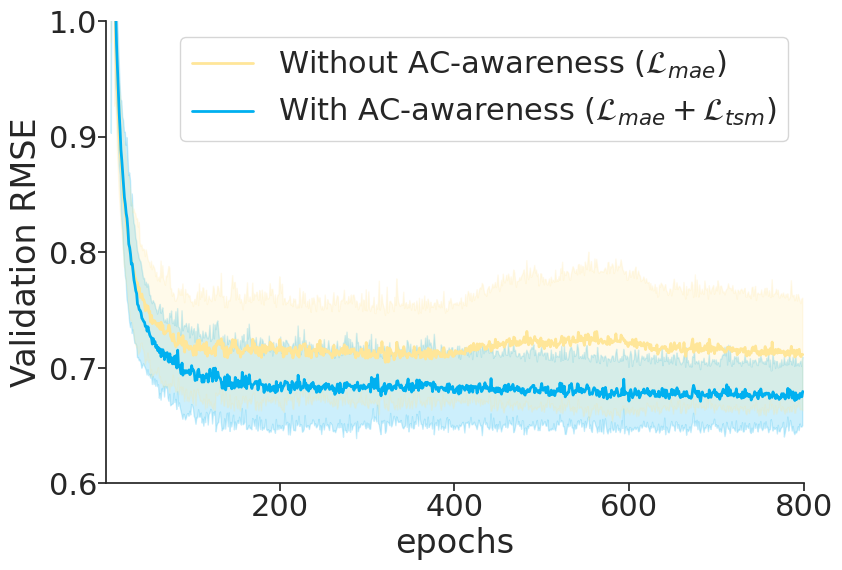

In [28]:
fig, ax = plt.subplots(figsize=(9, 6))
colors = ['#FFE699','#00B0F0']


y = 'val_rmse'

n1 = r'With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$)'
n2 = r'Without AC-awareness ($\mathcal{L}_{mae}$)'


dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.2)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.2)

ax.set_ylim(0.60, 1.0)
ax.set_ylabel('Validation RMSE')
ax.set_xlabel('epochs')
ax.spines[['right', 'top']].set_visible(False)

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Validation_RMSE.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./Validation_RMSE.pdf', bbox_inches='tight', dpi=400) 

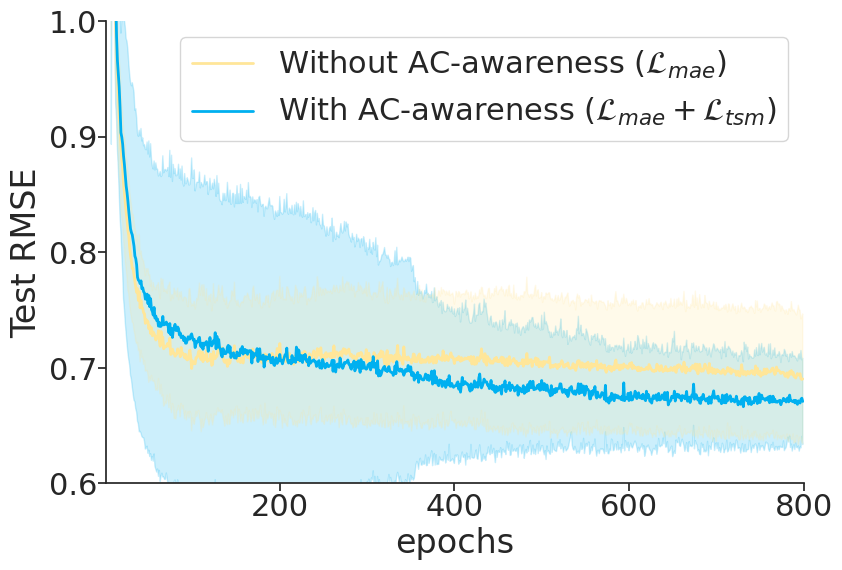

In [29]:
fig, ax = plt.subplots(figsize=(9, 6))
colors = ['#FFE699','#00B0F0']


y = 'test_rmse'



dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.2)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.2)

ax.set_ylim(0.60, 1.0)
ax.set_ylabel('Test RMSE')
ax.set_xlabel('epochs')
ax.spines[['right', 'top']].set_visible(False)

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Test_RMSE.svg' , bbox_inches='tight', dpi=400) 
fig.savefig('./Test_RMSE.pdf' , bbox_inches='tight', dpi=400) 

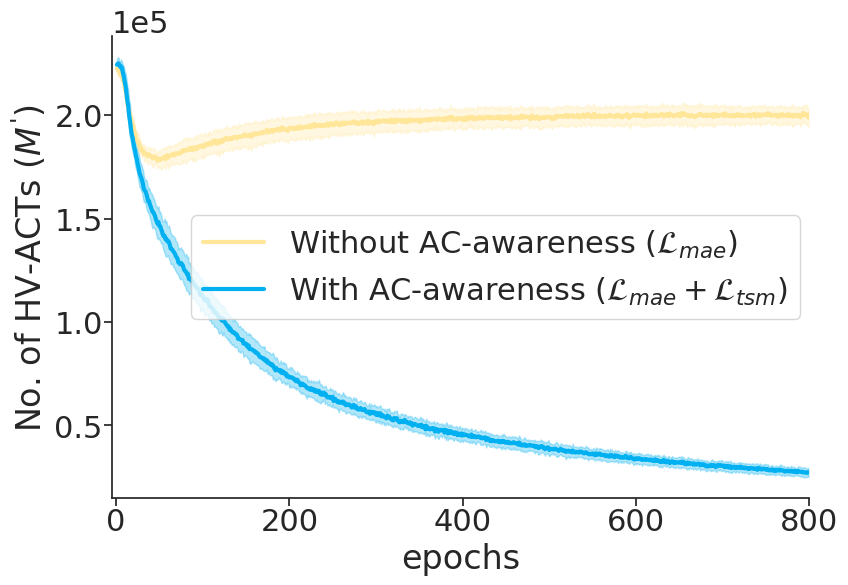

In [30]:
fig, ax = plt.subplots(figsize=(9, 6))


y = 'n_pos_triplets'

dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 3, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)

ax.legend(loc='center', bbox_to_anchor=(0.55, 0.5))

ax.spines[['right', 'top']].set_visible(False)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_ylabel("No. of HV-ACTs ($M^'$)")
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
ax.set_xlim(-5,800)


fig.savefig('./Number_of_mined_ACTs_during_training.svg' , bbox_inches='tight', dpi=400) 
fig.savefig('./Number_of_mined_ACTs_during_training.pdf' , bbox_inches='tight', dpi=400) 

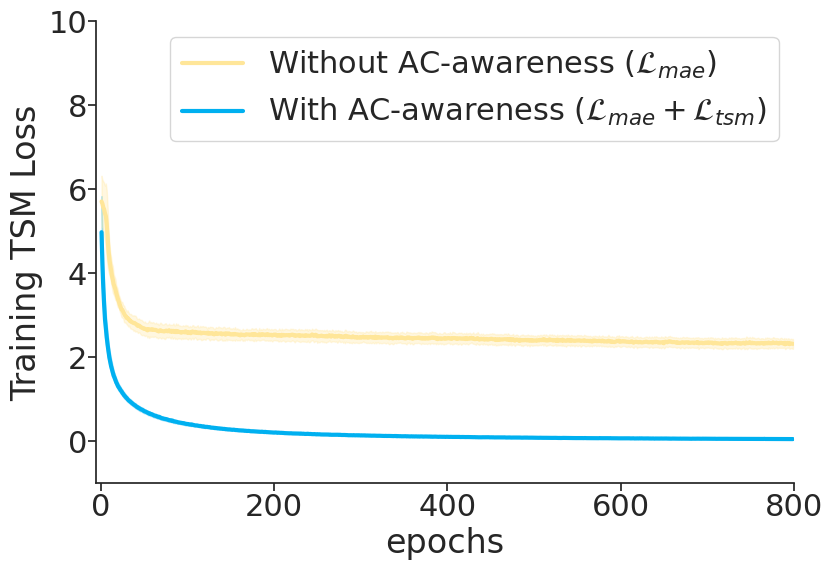

In [31]:
fig, ax = plt.subplots(figsize=(9, 6))
y = 'train_triplet_loss'
dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 3, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)

ax.spines[['right', 'top']].set_visible(False)
ax.set_xlim(-5,800)
ax.set_ylim(-1,10)

ax.set_ylabel('Training TSM Loss')
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Triplet_loss_during_training.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./Triplet_loss_during_training.pdf', bbox_inches='tight', dpi=400) 

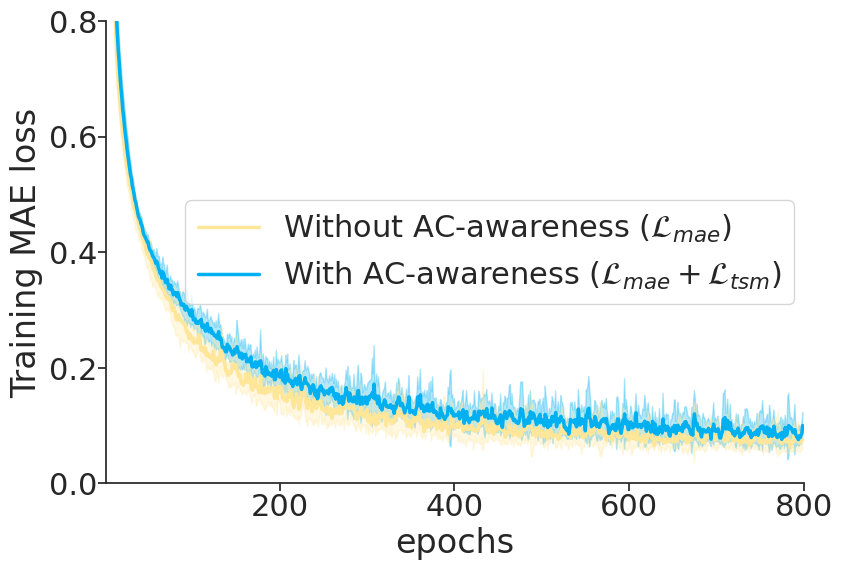

In [32]:
fig, ax = plt.subplots(figsize=(9, 6))

y = 'train_mae_loss'

dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2.5, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)



ax.set_ylim(0.0, 0.8)
ax.spines[['right', 'top']].set_visible(False)


ax.set_ylabel('Training MAE loss')
ax.set_xlabel('epochs')
ax.legend(loc='center', bbox_to_anchor=(0.55, 0.5))

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Train_mae_los.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./Train_mae_los.pdf', bbox_inches='tight', dpi=400) 